In [5]:
import tifffile
import cv2
import numpy as np
import matplotlib.pyplot as plt

from deepcell.utils.plot_utils import make_outline_overlay, create_rgb_image

def create_outline(im, mask):
    
    rgb = create_rgb_image(im, ["blue"])
    outline = make_outline_overlay(rgb, mask)
    
    return outline.squeeze()

In [9]:
from natsort import natsorted

base = "/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/dataset/rawimages"
base2 = "/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/dataset/groundtruth"

celltype = "Neuroblastom"

ims = natsorted([os.path.join(base, x) for x in os.listdir(base) if not x.startswith(".")])
masks = natsorted([os.path.join(base2, x) for x in os.listdir(base) if not x.startswith(".")])

ims = [x for x in ims if celltype in x]
masks = [x for x in masks if celltype in x]

len(ims), len(masks)

(18, 18)

In [7]:
from CellClass import MCImage
from CellClass.Segment import Segmentation
from CellClass.Preprocessing import h_dome, apply_clahe

In [8]:
S = Segmentation("deepcell")
all_mpps = []
for s, (p, m) in enumerate(zip(ims, masks)):
    
    print(p.split("/")[-1])
    im = tifffile.imread(p)
    if im.ndim == 3:
        im = im[..., 0]
    mask = tifffile.imread(m)
    
    print(im.shape, mask.shape)
    mpps = []
    for l in np.linspace(0.165,0.25,10):
        ret_im, ret_mask, o = S(im, return_outline=True, image_mpp=l)
    # plt.imshow(o)
    # plt.show()
        all_mpps.append({
            "sample": s,
            "mmp": l,
            "pred_max": ret_mask.max(),
            "target_max": mask.max(),
            "diff": mask.max()-ret_mask.max()
            })

    
    # im = np.expand_dims(np.expand_dims(im, -1), 0)
    # mask = np.expand_dims(np.expand_dims(mask, -1), 0)
    # o = create_outline(im, mask)
    
    # plt.imshow(o)
    # plt.show()


Neuroblastoma_0.tif
(1024, 1280) (1024, 1280)


TypeError: eval() got an unexpected keyword argument 'image_mpp'

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(all_mpps)
df.head()

In [ ]:
list(set(df["sample"]))

In [ ]:
best = []
for s in list(set(df["sample"])):
    tmp = df[df["sample"] == s]
    print(tmp)
    print(abs(tmp["diff"]).min())
    best.extend(list(tmp[abs(tmp["diff"]) == abs(tmp["diff"]).min()].mmp))
    

In [ ]:
from collections import Counter

Counter(best)

In [10]:
algorithm = "cellpose"
S = Segmentation(algorithm)
for s, (p, m) in enumerate(zip(ims, masks)):
    
    sample = p.split("/")[-1]
    print(p.split("/")[-1])
    im = tifffile.imread(p)
    if im.ndim == 3:
        im = im[..., 0]
    mask = tifffile.imread(m)
    ret_im, ret_mask, o = S(im, return_outline=True)
    if not os.path.isdir(f"/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_{algorithm}"):
        os.mkdir(f"/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_{algorithm}")
        
    cv2.imwrite(f"/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_{algorithm}/{sample}",ret_mask)


Neuroblastoma_0.tif
Neuroblastoma_1.tif
Neuroblastoma_2.tif
Neuroblastoma_3.tif
Neuroblastoma_4.tif
Neuroblastoma_5.tif
Neuroblastoma_6.tif
Neuroblastoma_7.tif
Neuroblastoma_8.tif
Neuroblastoma_9.tif
Neuroblastoma_10.tif
Neuroblastoma_11.tif
Neuroblastoma_12.tif
Neuroblastoma_13.tif
Neuroblastoma_14.tif
Neuroblastoma_15.tif
Neuroblastoma_16.tif
Neuroblastoma_17.tif


In [11]:
from natsort import natsorted

base = "/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/dataset/rawimages"
base2 = "/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/dataset/groundtruth"
base3 = f"/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_{algorithm}"

celltype = "Neuroblastom"

ims = natsorted([os.path.join(base, x) for x in os.listdir(base) if not x.startswith(".")])
masks = natsorted([os.path.join(base2, x) for x in os.listdir(base) if not x.startswith(".")])
preds = natsorted([os.path.join(base3, x) for x in os.listdir(base) if not x.startswith(".")])

ims = [x for x in ims if celltype in x]
masks = [x for x in masks if celltype in x]
preds = [x for x in preds if celltype in x]

len(ims), len(masks), len(preds)

(18, 18, 18)

In [40]:
def find_corresponding(target, pred):
    
    cell_idxs = np.unique(pred)
    cell_idxs = cell_idxs[cell_idxs != 0]
    
    if len(cell_idxs) == 0:
        return 0
    if len(cell_idxs) == 1:
        return cell_idxs[0]
    else:
        ret = [np.sum(pred == c) for c in cell_idxs]
        return cell_idxs[np.where(ret == max(ret))][0]
    

In [41]:
def dice(target, pred):
    
    A = target.astype(bool)
    B = pred.astype(bool)
    
    A_n_B = np.sum(A * B)

    
    return 2*A_n_B/(np.sum(A)+np.sum(B))
    
def jaccard(target, pred):
    
    A = target.astype(bool)
    B = pred.astype(bool)
    
    A_n_B = np.sum(A * B)
    A_u_B = np.sum(A | B)

    return A_n_B/A_u_B

def prec_recall(target, pred):
    
    A = target.astype(bool)
    B = pred.astype(bool)
    
    TP = np.sum(A * B)
    FP = np.sum(np.invert(B) * A)
    FN = np.sum(np.invert(A) * B)
    
    #plt.imshow(additive_blend(target, pred)); plt.show()
    #print(TP, FP, FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    #äprint(f"PRECISION: {precision} || RECALL: {recall}")
    return precision, recall

In [42]:
from workflow.utils import additive_blend

In [43]:
def erode_mask(mask, s=3):
            
    k = np.ones((s,s)).astype(np.uint8)
    ret = cv2.erode(mask.astype(np.uint8), k)
    return ret.astype(bool)

In [58]:
from tqdm import tqdm

res = []
print(preds)
for t, p in tqdm(zip(masks, preds)):
    target = tifffile.imread(t)
    pred = tifffile.imread(p)
    
    # plt.imshow(target); plt.show()
    # plt.imshow(pred); plt.show()

    for c in range(1, target.max()+1):
        
        tmp = np.copy(target)
        tmp[tmp != c] = 0
        
        if tmp.any():
            y, x = np.where(tmp != 0)
            y_min, y_max = y.min(), y.max()+1
            x_min, x_max = x.min(), x.max()+1

            if y_min == 0 or y_max == target.shape[0] or x_min==0 or x_max==target.shape[1]:
                continue
        else:
            continue
        
        tmp_pred = np.copy(pred)
        tmp_pred[tmp == 0] = 0
        
        cell_idx = find_corresponding(tmp, tmp_pred)
        
        if cell_idx != 0:
            tmp_pred = np.copy(pred)
            tmp_pred[tmp_pred != cell_idx] = 0

            b_prec, b_rec = prec_recall(tmp, tmp_pred)
            
            b_d = dice(tmp, tmp_pred)
            b_j = jaccard(tmp, tmp_pred)
                
            res.append({
                    "n": "b",
                    "val": b_d,
                    "mod":  "dice"
                })
            res.append({
                    "n": "b",
                    "val": b_j,
                    "mod":  "jacc"
                })
            res.append({
                    "n": "b",
                    "val": b_prec,
                    "mod":  "prec"
                })
            res.append({
                    "n": "b",
                    "val": b_rec,
                    "mod":  "rec"
                })

['/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_cellpose/Neuroblastoma_0.tif', '/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_cellpose/Neuroblastoma_1.tif', '/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_cellpose/Neuroblastoma_2.tif', '/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_cellpose/Neuroblastoma_3.tif', '/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_cellpose/Neuroblastoma_4.tif', '/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_cellpose/Neuroblastoma_5.tif', '/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_cellpose/Neuroblastoma_6.tif', '/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_cellpose/Neuroblastoma_7.tif', '/data_isilon_main/isilon_images/10_MetaSystems/Segmentation_Dataset/predictions_cellpose/Neuroblastoma

18it [00:22,  1.26s/it]


In [59]:
import pandas as pd
res = pd.DataFrame(res)

In [60]:
len(res[res.n == "b"])

1508

In [61]:
l = natsorted(list(np.unique(res.n)))
l.remove("b")
l.insert(0, "b")
l

['b']

In [62]:
import seaborn as sb

(-0.1, 1.1)

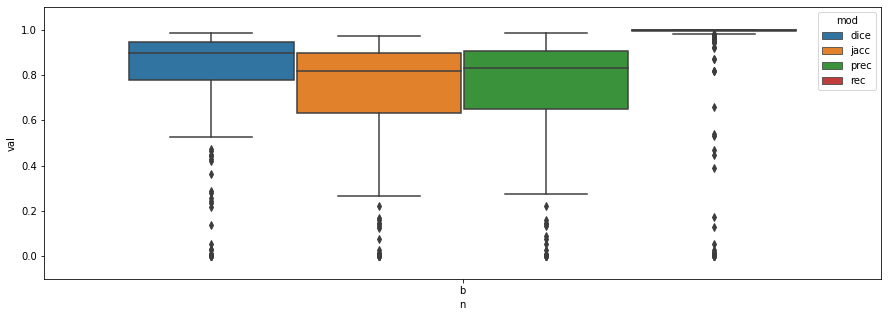

In [65]:
plt.rcParams["figure.figsize"] = 15,5
ax = sb.boxplot(x="n", y="val", hue="mod", data=res,order =l )
#ax.plot([i, i], [-0.1,1.1], "--k")
ax.set_ylim(-0.1,1.1)
#ax.set_xlim(-0.5,7.5)